### Setup

- Difffusers

In [ ]:
# !git clone https://github.com/huggingface/diffusers.git
# %cd diffusers
# !pip install .
# %cd ..

- Peft

In [ ]:
# !git clone https://github.com/huggingface/peft.git
# %cd peft
# !pip install .
# %cd ..

- Library

In [2]:
import torch, transformers, datasets, diffusers, accelerate, peft
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import json
from datasets import Dataset, DatasetDict
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
import transformers, datasets, diffusers
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.training_utils import cast_training_params

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

from tqdm import tqdm
from PIL import Image
from huggingface_hub import login

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : ',device)   
print('package version : ',torch.__version__, transformers.__version__, datasets.__version__, diffusers.__version__, peft.__version__)

device :  cuda
package version :  2.3.0.post101 4.46.2 3.0.1 0.33.0.dev0 0.7.0


In [4]:
# CONFIGURATION

# hugging face login
CONFIG_PATH = '../config.json'
with open(CONFIG_PATH,'r') as f:
    config = json.load(f)
HUGGING_FACE_TOKEN = config.get("HUGGING_FACE_TOKEN")
login(HUGGING_FACE_TOKEN)

### Load Data

In [5]:
image_folder = '../Data/Seed/Seed_Image'
label_folder = '../Data/Seed/EN_Seed_Label'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith('.json')])

data = []
for image_file, label_file in zip(image_files, label_files):
    image_path = os.path.join(image_folder, image_file)
    label_path = os.path.join(label_folder, label_file)
    # 이미지 파일 열기
    with open(image_path, 'rb') as image:
        image_data = Image.open(image)
        image_data = image_data.convert('RGB') # RGB로 변환
        
    # 라벨 파일 열기
    with open(label_path, 'r') as label:
        label_data = json.load(label)
        
    # 이미지와 라벨 데이터 묶기
    data.append({
        'image':image_data,
        'text':label_data
    })
    
# dataset으로 변환
dataset = Dataset.from_dict({
    'image': [item['image'] for item in data],
    'text': [str(item['text']) for item in data]
    # 'text': [str(item['text'])[:76] for item in data] # max length 76
})
# 최종 dataset 출력
dataset = DatasetDict({
    'train': dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 230
    })
})

### Load Model
- 노이즈 스케쥴러, 텍스트 토크나이저, 텍스트 인코더, 이미지 오토인코더, unet 모델을 선학습된 상태로 각각 로딩

In [9]:
PRE_TRAINED_MODEL_NAME="runwayml/stable-diffusion-v1-5"
PRE_TRAINED_MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)
tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)
text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

# 모델에 입력되는 최대 토큰 길이
tokenizer.model_max_length

77

### Preprocess Data

- Preprocess Image Data

In [7]:
# 데이터 셋의 한 샘플에 대해서 text컬럼을 토크나이징하는 함수
def tokenize_captions(examples, caption_column='text', is_train=True):
    captions = []

    for caption in examples[caption_column]:
        # 캡션이 하나인 경우
        if isinstance(caption, str):
            captions.append(caption)
        # 캡션이 하나 이상인 경우 아무거나 하나 선택
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids

- Preprocess Image Data

In [18]:
IMG_SIZE = 512
CENTER_CROP = True
RANDOM_FLIP = True

train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

- Total Preprocess Function

In [9]:
def preprocess_train(examples, image_column='image'):
    images = [image.convert("RGB") for image in examples[image_column]]
    # 이미지 전처리
    examples["pixel_values"] = [train_transforms(image) for image in images]
    # 텍스트 전처리
    examples["input_ids"] = tokenize_captions(examples)
    return examples

### Data Loader

In [10]:
def collate_fn(examples):
    # (C, H, W), ..., (C, H, W) -> stack -> (N, C, H, W): N으로 스택
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # tensor.contiguous()와 동일
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # {(77,), ..., (77,)}_N개 -> stack -> (N, 77)
    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [19]:
BATCH_SIZE = 4
NUM_WORKERS = 4

# 데이터 실시간 변환 적용
train_dataset = dataset["train"].with_transform(preprocess_train)

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [20]:
# 데이터 로더 테스트
train_dataloader_iter = iter(train_dataloader)
mini_batch = next(train_dataloader_iter)

# 이미지 데이터, 캡션 데이터
print('Image Data : ', mini_batch['pixel_values'].shape)
print('Caption Data : ', mini_batch['input_ids'].shape)

# 참고 text_encoder의 출력
# BaseModelOutputWithPooling 이 되돌려지는데 [0]이 last_hidden_state
# 트랜스포머 인코더의 마지막 히든층 츨력이므로 크기는 (batch size, time step, model dim)
print('Text Encoder : ', text_encoder(mini_batch['input_ids'])[0].shape)

Image Data :  torch.Size([4, 3, 512, 512])
Caption Data :  torch.Size([4, 77])
Text Encoder :  torch.Size([4, 77, 768])


### Load Model

In [21]:
# FP16을 AMP으로 적용하기 위한 세팅
weight_dtype = torch.float16 
# unet, vae와 텍스트 인코더는 미세조정에서 학습되지 않음
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False);

# LoRA Adapter 준비
LORA_RANK = 4
# Freeze the unet parameters before adding adapters
for param in unet.parameters():
    param.requires_grad_(False)
unet_lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

# GPU로 이동
text_encoder.to(device);
vae.to(device);
unet.to(device);

# Add adapter and make sure the trainable params are in float32.
unet.add_adapter(unet_lora_config)

# Cast the trainable parameters to float32
if weight_dtype == torch.float16:
    # only upcast trainable parameters (LoRA) into fp32
    cast_training_params(unet, dtype=torch.float32)

lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

- Optimizer와 Scheduler 설정

In [22]:
EPOCHS = 3
LEARNING_RATE = 1e-04

optimizer = torch.optim.AdamW(
        lora_layers,
        lr=LEARNING_RATE,
    )

lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=EPOCHS * len(train_dataloader)
    )

### Train Loop

In [23]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None # 'epsilon'  or 'v_prediction'

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_dataloader)):
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            # Convert images to latent space
            latents = vae.encode(
                batch["pixel_values"].to(device)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning, [0]: last_hidden_state
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            # 노이즈 스케쥴러에 예측 타입이 노이즈인지 이미지인지에 따라 타겟 설정
            if prediction_type is not None:
                # set prediction_type of scheduler if defined
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        with torch.no_grad():
            train_losses.append(loss.item())

        # loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()

    # print loss
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')


  0%|          | 0/58 [00:00<?, ?it/s]/home/gayeon38/anaconda3/envs/vlm-env/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1725570624180/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


Finished epoch 1. Average of the last 100 loss values: 0.054469


100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


Finished epoch 2. Average of the last 100 loss values: 0.099315


100%|██████████| 58/58 [00:12<00:00,  4.49it/s]

Finished epoch 3. Average of the last 100 loss values: 0.096214


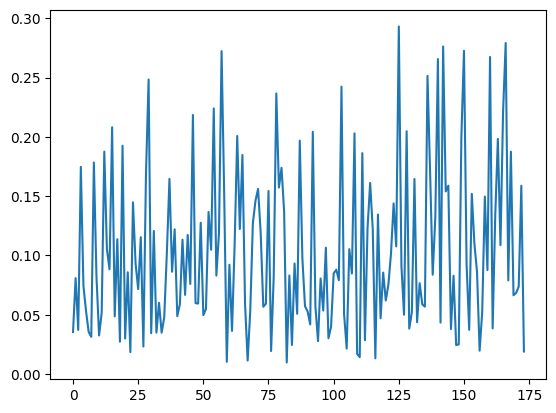

In [16]:
plt.plot(train_losses)
plt.show()

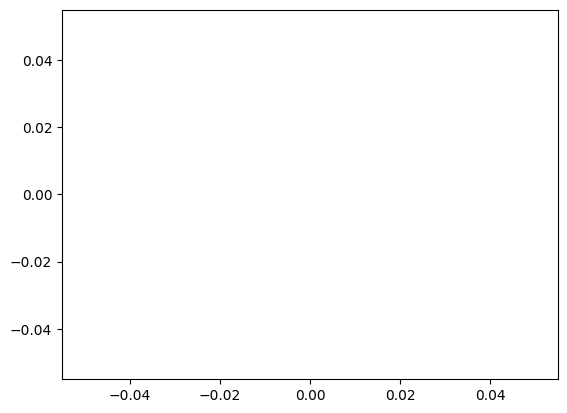

In [17]:
losses_sr = pd.Series(train_losses)
loss_mv = losses_sr.rolling(window=300).mean()
plt.plot(loss_mv)

### Generate Image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

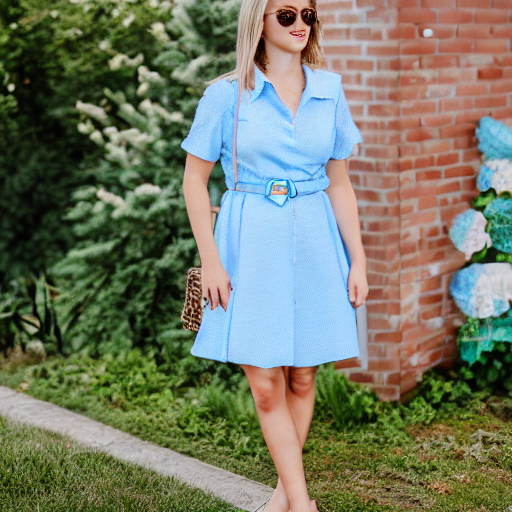

In [18]:
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet, # 미세 조정된 네트워크
)
pipeline.to(device);
lora_scale = 0.9
pipeline_output = pipeline(
    prompt=["a sky blue dress with a white belt and a white collar"],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)
pipeline_output.images[0]

### Save Fine-Tuned Model

In [19]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# save model 
pipeline.save_pretrained(f"../Experiment/model/FIGMA_{current_time}")
# save model weights
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))
StableDiffusionPipeline.save_lora_weights(
    save_directory=f"../Experiment/model_weights/FIGMA_weights_{current_time}",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

### Push To Hugging Face

In [20]:
REPO_NAME = "GAYOEN/FIGMA_finetune_stable-diffusion-v1-5"
pipeline.push_to_hub(REPO_NAME)

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/GAYOEN/FIGMA_finetune_stable-diffusion-v1-5/commit/c68190e73cd0445ae524b89cd17c22c3e9b434a9', commit_message='Upload StableDiffusionPipeline', commit_description='', oid='c68190e73cd0445ae524b89cd17c22c3e9b434a9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/GAYOEN/FIGMA_finetune_stable-diffusion-v1-5', endpoint='https://huggingface.co', repo_type='model', repo_id='GAYOEN/FIGMA_finetune_stable-diffusion-v1-5'), pr_revision=None, pr_num=None)